In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!pip install visualkeras
!pip install tensorflow_addons


In [25]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.backend as K

import random
import os
import keras
import visualkeras

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.applications.inception_v3 import InceptionV3
from keras import optimizers, layers, applications

In [26]:
filenames = os.listdir("/content/drive/MyDrive/Colab Notebooks/AutismDataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

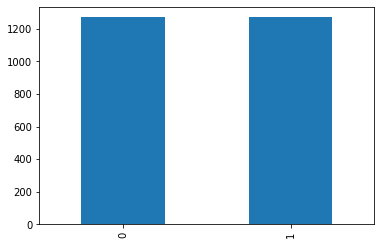

In [27]:
train_df['category'].value_counts().plot.bar()

In [28]:
test_filenames = os.listdir("/content/drive/MyDrive/Colab Notebooks/AutismDataset/test")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

test_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

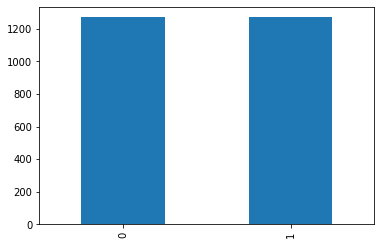

In [29]:
test_df['category'].value_counts().plot.bar()

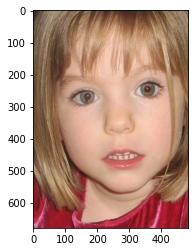

In [30]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/Colab Notebooks/AutismDataset/train/"+sample)
plt.imshow(image)

In [31]:
image_size = 224

In [32]:
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()



total_train = train_df.shape[0]
total_validate = validate_df.shape[0]


In [33]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/Colab Notebooks/AutismDataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=64
)

Found 2286 validated image filenames belonging to 2 classes.


In [34]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/Colab Notebooks/AutismDataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=64
)

Found 254 validated image filenames belonging to 2 classes.


In [35]:
model = InceptionV3(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

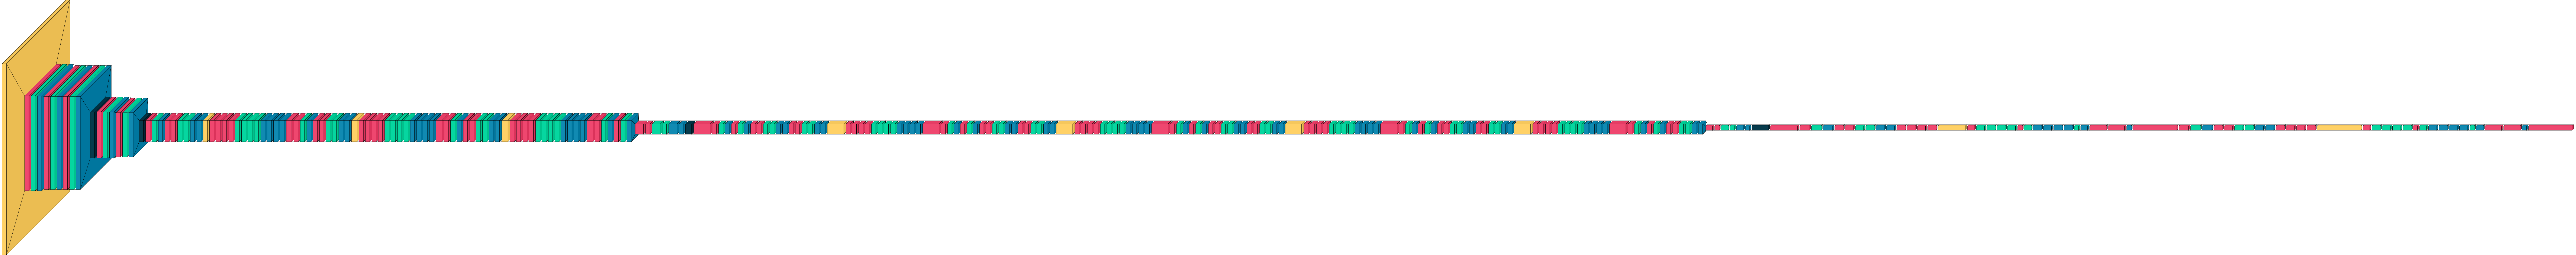

In [36]:
visualkeras.layered_view(model)

In [37]:
last_output= model.layers[-1].output

last_output= Flatten()(last_output)

pretrained_model= Model(model.input, last_output) 

In [38]:
x= Dense(units=128, activation="relu")(last_output)
x=Dropout(0.2)(x)

x= Dense(units=32, activation="relu")(x)
x=Dropout(0.2)(x)

x= Dense(units=1, activation="sigmoid")(x)

model= Model(pretrained_model.input, x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

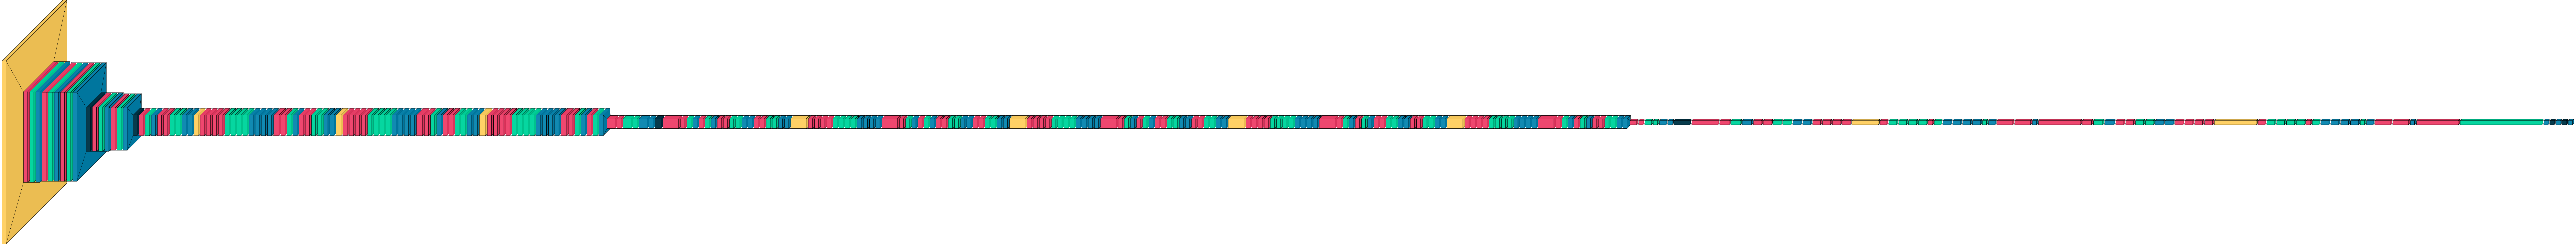

In [40]:
visualkeras.layered_view(model)

In [41]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [42]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='acuracia'),
      tf.keras.metrics.Precision(name='precisão'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [43]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [44]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
              metrics=METRICS)

#VGG.compile(optimizer='optimizers.SGD(lr=1e-3, momentum=0.9)', loss='categorical_crossentropy',metrics=METRICS)

#optimizer=optimizers.SGD(lr=1e-3, momentum=0.9))



In [45]:
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator,
    validation_steps=total_validate//64
)

'''
history = VGG.fit(train_generator,
                  validation_data=validation_generator,
                    validation_steps=total_validate//64,
                    epochs = 20,
                    steps_per_epoch=total_train//64,
                    verbose = 1,
                    callbacks=lr_scheduler)
'''

Epoch 1/200


InvalidArgumentError: ignored

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" Metricas do modelo ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Acuracia')
    ax1.set_xlabel('Folds')
    ax1.set_ylabel('Acuracia')
    ax1.legend(['Treino', 'Teste'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Folds')
    ax2.set_ylabel('Loss')
    ax1.legend(['Treino', 'Teste'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC')
    ax3.set_xlabel('Folds')
    ax3.set_ylabel('AUC')
    ax1.legend(['Treino', 'Teste'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('Precisão')
    ax4.set_xlabel('Folds')
    ax4.set_ylabel('Precisão')
    ax1.legend(['Treino', 'Teste'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('F1-score')
    ax5.set_xlabel('Folds')
    ax5.set_ylabel('F1 score')
    ax1.legend(['Treino', 'Teste'])


    plt.show()
    

Train_Val_Plot(history.history['acuracia'],history.history['val_acuracia'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precisão'],history.history['val_precisão'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
train_data, train_labels = train_generator.next()

In [ ]:
#Dividindo os dados em conjuntos de treinamento, teste e validação

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
test_scores = model.evaluate(test_data, test_labels)

print("Accuracia = ", test_scores[1])
print("Precisão = ", test_scores[2])
print("Recall = ", test_scores[3])
print("AUC = ", test_scores[4])
print("F1_score = ", test_scores[5])

In [ ]:
pred_labels = model.predict(test_data)

In [ ]:
kpred = model.predict(test_data)

In [ ]:
pred = kpred.tolist()
predictions = []
for i in pred:
  predictions.append(i.index(max(i)))

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [ ]:
CLASSES = [ 'Autistic',
            'Non_Autistic'
            ]

In [ ]:
#Como os rótulos são arrays softmax, precisamos arredondar para tê-los na forma de 0s e 1s,
#semelhante aos test_labels
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

In [ ]:
#Plotar a matriz de confusão para entender a classificação em detalhes

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Diagnóstico da Doença de Alzheimer')
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.show(ax)